# Resilience of London Tube

## Measures

## Analysis

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import copy
import seaborn as sns

In [2]:
# You need to set the working directory to where you have your shapefile data
# Let's create a graph from the shapefile
g_shp=nx.read_shp('./underground/underground.shp',geom_attrs=False)

# We can print the dataframe from the shapefile to check the data
df = nx.to_pandas_edgelist(g_shp)

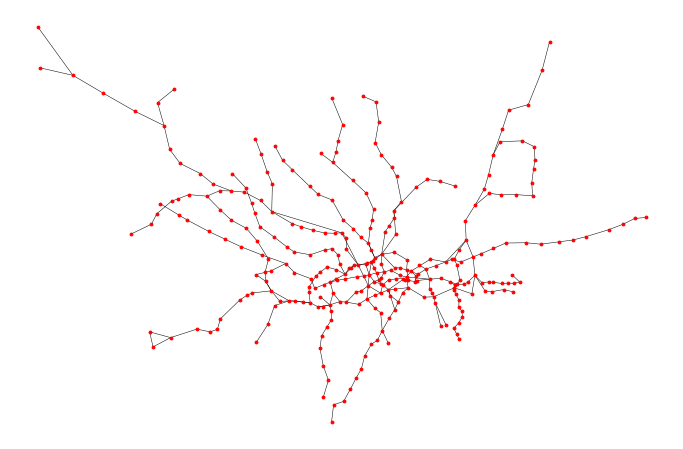

In [3]:
#plot the tube network without label:
#########################################

# first we need to extract the coordinates from every node:
pos = {xy: xy for xy in g_shp.nodes()}

fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx_nodes(g_shp,pos,node_size=8,node_color='r')
nx.draw_networkx_edges(g_shp,pos,arrows=False,width=0.5)
plt.axis("off")
plt.savefig('0.network_nolabel.png')

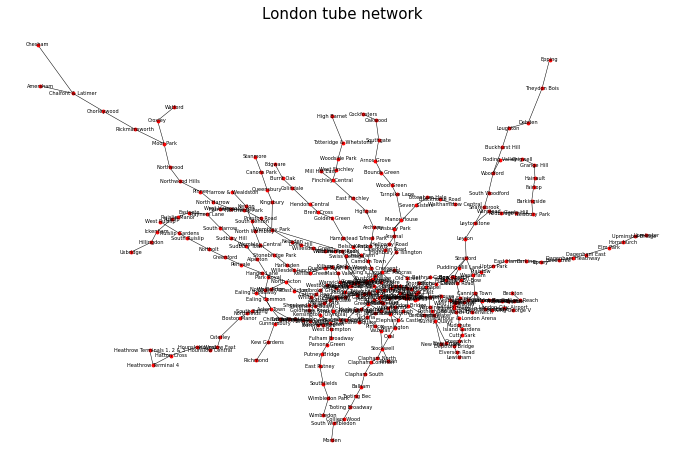

In [4]:
#plot the tube network with label:
#########################################


#we will need to add station names as attributes of the nodes:
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}
#nod_all = {**nod_st1, **nod_st2} #for python 3.5 and greater

#In Python 2, (or 3.4 or lower) write a function
nod_all = nod_st1.copy()   # start with x's keys and values
nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

#We can plot the underground network with stations names:
fig, ax = plt.subplots(figsize=(12,8))

node_labels = nx.get_node_attributes(g_shp, 'station')

pos = {xy: xy for xy in g_shp.nodes()}

nx.draw_networkx_nodes(g_shp,pos,node_size=8,node_color='r')
nx.draw_networkx_edges(g_shp,pos,arrows=False,width=0.5)
nx.draw_networkx_labels(g_shp,pos, node_labels, font_size=5,font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.savefig('0.network_label.png')

In [5]:
# directed ----> undirected
#########################################


#do we want this graph to be a directed one? In fact, only a few links in the dataset are directed

# We can transform the type of graph from directed to undirected using the following function:
g_shp_un = g_shp.to_undirected()

#Finally, we will give an ID to each node(station), such that it will be easier later to call them:
#1.Create a new attribute with node coordinates (now coord are the keys and we do not want to lose that information
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')

#2.now relabel each node with an ordered integer:
node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)

---

### Degree

In [6]:
#degree unseq
#########################################################

#Let us compute the degree centrality
deg=nx.degree(g_shp_un)

nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,dict(deg),'degree')

## degree centrality
deg_norm =nx.degree_centrality(g_shp_un)

nx.set_node_attributes(g_shp_un,dict(deg_norm),'degree_norm')

deg_color_norm=[(node['degree_norm']) for i, node in g_shp_un.nodes(data=True)]
deg_size_norm=[(node['degree_norm']*1000) for i, node in g_shp_un.nodes(data=True)]

#get a list of nodes with higeher betweeness centrality:
dict_bet_un=dict(g_shp_un.nodes(data=True))

#Python2:
#import operator
#listbet_un=sorted(dict_bet_un.items(), key=operator.itemgetter(1),reverse=True)
#listbet_un[:10]

#Pyhton3:
from collections import OrderedDict
listbet_un=OrderedDict(sorted(dict_bet_un.items(), 
                              key=lambda x: x[1]['degree_norm'],
                              reverse=True))
list(listbet_un.items())[:15]
list_degree = list(listbet_un.items())[:15]

list_degree1 = []
list_degree1_station = []

for i in list_degree:
    list_degree1.append(i[0])
    list_degree1_station.append(i[1].get('station'))

degree_unse_trend = []

degree_unse_path = []
degree_unse_diameter = []
degree_unse_path_norm = []
degree_unse_diameter_norm = []
degree_unse_cluster = []
degree_unse_aver_deg =[]
G = copy.deepcopy(g_shp_un)

for i in range(0,15):

    G.remove_node(list_degree1[i])
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    degree_unse_trend.append(len(G0))
    degrees = [val for (node, val) in G.degree()]
    degree_unse_aver_deg.append(sum(degrees)/len(degrees))

    degree_unse_path.append(nx.average_shortest_path_length(G0,
                                                            weight='distance'))
    degree_unse_path_norm.append(nx.average_shortest_path_length(G0,
                                                                 weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, 
                                                    weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    degree_unse_diameter.append(d)
    degree_unse_diameter_norm.append(d/len(G0))
    degree_unse_cluster.append(nx.average_clustering(G))
    
degree_unse = pd.DataFrame({'station':list_degree1_station[0:15],
                            'size':degree_unse_trend,
                            'degree':degree_unse_aver_deg,
                            'diameter':degree_unse_diameter_norm})

In [7]:
#degree seq
#########################################################
degree_station = []
degree_trend = []
degree_node = []
degree_path = []
degree_diameter = []
degree_path_norm = []
degree_diameter_norm = []
degree_cluster = []
degree_aver_deg =[]
G = copy.deepcopy(g_shp_un)
for i in range(0,15):

    deg_norm =nx.degree_centrality(G)
    nx.set_node_attributes(G,dict(deg_norm),'degree_norm')
    dict_un=dict(G.nodes(data=True))
   
    degree_station.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['degree_norm'],reverse=True)).items())[0][1].get('station'))
    degree_node.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['degree_norm'],reverse=True)).items())[0][0])
    G.remove_node(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['degree_norm'],reverse=True)).items())[0][0])
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    degrees = [val for (node, val) in G.degree()]
    degree_aver_deg.append(sum(degrees)/len(degrees))
    degree_trend.append(len(G0))
    degree_path.append(nx.average_shortest_path_length(G0,weight='distance'))
    degree_path_norm.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    degree_diameter.append(d)
    degree_diameter_norm.append(d/len(G0))
    degree_cluster.append(nx.average_clustering(G))

degree_se = pd.DataFrame({'station':degree_station[0:15],'size':degree_trend,'degree':degree_aver_deg,'diameter':degree_diameter_norm})

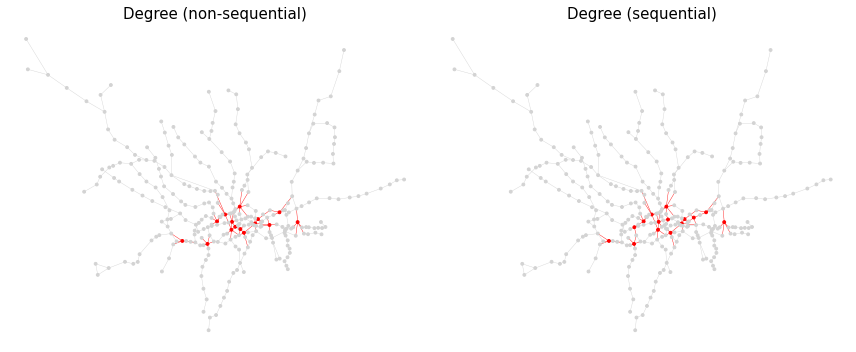

In [8]:
# degree_network_UnSeq_VS_Seq.png
node_color=[]
edge_color = []
for node in g_shp_un.nodes(data = True):
    if node[0] in list_degree1[0:15]:
        node_color.append('red')
    else:
        node_color.append('lightgrey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(list_degree1[0:15]):
        edge_color.append('red')
    else:
        edge_color.append('lightgrey')

#add edges linking nodes:



node_color1=[]
edge_color1 = []
for node in g_shp_un.nodes(data = True):
    if node[0] in degree_node:
        node_color1.append('red')
    else:
        node_color1.append('lightgrey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(degree_node):
        edge_color1.append('red')
    else:
        edge_color1.append('lightgrey')

#add edges linking nodes:

pos={e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

fig, axes = plt.subplots(1, 2,figsize=(12,5))
ax = axes.flatten()
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color, 
        width=0.4, ax=ax[0])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color,
        node_size=8, ax=ax[0])


ax[0].set_axis_off()
ax[0].set_title("Degree (non-sequential)",fontsize=15)
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color1, 
        width=0.4, ax=ax[1])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color1,
        node_size=8, ax=ax[1])

ax[1].set_axis_off()
ax[1].set_title("Degree (sequential)",fontsize=15)
fig.tight_layout()
plt.savefig('1.1.degree_network_UnSeq_VS_Seq.png')

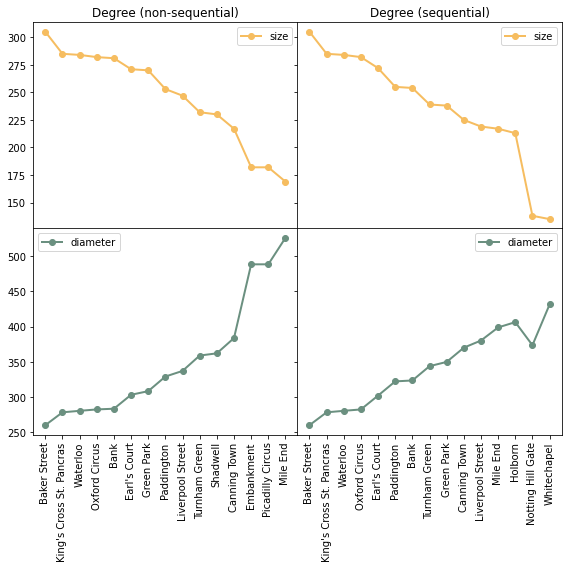

In [9]:
# degree_Size_D_UnSeq_VS_Seq.png

fig= plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax3), (ax2, ax4) = gs.subplots(sharex='col',sharey='row')
# multiple line plots
ax1.plot( 'station', 'size', data=degree_unse, marker='o', color='#f6bd60', linewidth=2)
ax2.plot( 'station', 'diameter', data=degree_unse, marker='o',color='#6b9080', linewidth=2)

# show legend
ax1.legend()
ax2.legend()

ax2.tick_params('x', labelrotation=90)
ax1.set_title('Degree (non-sequential)')
# multiple line plots
ax3.plot( 'station', 'size', data=degree_se, marker='o', color='#f6bd60', linewidth=2)
ax4.plot( 'station', 'diameter', data=degree_se, marker='o', color='#6b9080', linewidth=2)
ax3.legend()
ax4.legend()
ax4.tick_params('x', labelrotation=90)
ax3.set_title('Degree (sequential)')


# show graph
fig.tight_layout()
plt.savefig('1.2.degree_Size_D_UnSeq_VS_Seq.png')


In [10]:
# station_between_list & csv
station_degree_seq = pd.DataFrame()

station_degree_seq = degree_se[['station','degree','size','diameter']]

station_degree_seq = degree_unse[['station','degree','size','diameter']]

station_degree_seq.to_csv('1.3.degree-result.csv')
station_degree_seq

,station,degree,size,diameter
0,Baker Street,2.268852,305,260.109150
1,King's Cross St. Pancras,2.230263,285,278.362423
2,Waterloo,2.198020,284,280.470903
3,Oxford Circus,2.165563,282,282.460058
4,Bank,2.139535,281,283.465254
5,Earl's Court,2.106667,271,303.232836
6,Green Park,2.080268,270,308.389672
7,Paddington,2.053691,253,329.111508
8,Liverpool Street,2.033670,247,337.106119
9,Turnham Green,2.006757,232,358.901774


### Betweenness

In [11]:
#betweenness unseq
#########################################################

#Let's compare node centrality for the undirected tube network and the directed commuting flows network:
#Let us compute the betweenness centrality for the undirected tube network, considering the distance between stations:
bet_london_w=nx.betweenness_centrality(g_shp_un, weight='distance', normalized=False)
# We can add these values as node attributes:
nx.set_node_attributes(g_shp_un,bet_london_w,'betweenness_un')

# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_un']) for i in g_shp_un.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_un']/max(betweenness_w_values)) for i in g_shp_un.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_un']/max(betweenness_w_values)*100) for i in g_shp_un.nodes(data=True)]

#get a list of nodes with higeher betweeness centrality:
dict_bet_un=dict(g_shp_un.nodes(data=True))

#Python2:
#import operator
#listbet_un=sorted(dict_bet_un.items(), key=operator.itemgetter(1),reverse=True)
#listbet_un[:10]

#Pyhton3:
from collections import OrderedDict
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
list_between = list(listbet_un.items())[:15]

list_between1 = []
list_between1_station = []

for i in list_between:
    list_between1.append(i[0])
    list_between1_station.append(i[1].get('station'))


between_unse_trend = []
between_unse_node = []
between_unse_path = []
between_unse_diameter = []
between_unse_path_norm = []
between_unse_diameter_norm = []
between_unse_cluster = []
between_unse_aver_deg =[]
G = copy.deepcopy(g_shp_un)

for i in range(0,15):
    G.remove_node(list_between1[i])
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    between_unse_trend.append(len(G0))
    degrees = [val for (node, val) in G.degree()]
    between_unse_aver_deg.append(sum(degrees)/len(degrees))
    between_unse_path.append(nx.average_shortest_path_length(G0,weight='distance'))
    between_unse_path_norm.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    between_unse_diameter.append(d)
    between_unse_diameter_norm.append(d/len(G0))
    between_unse_cluster.append(nx.average_clustering(G))

between_unse = pd.DataFrame({'station':list_between1_station[0:15],'size':between_unse_trend,'degree':between_unse_aver_deg,'diameter':between_unse_diameter_norm})

In [12]:
#betweenness seq
#########################################################
between_station = []
between_trend = []
between_node = []
between_path = []
between_diameter = []
between_path_norm = []
between_diameter_norm = []
between_cluster = []
between_aver_deg =[]
G = copy.deepcopy(g_shp_un)
for i in range(0,15):

    bet_london_w=nx.betweenness_centrality(G, weight='distance', normalized=False)
    nx.set_node_attributes(G,bet_london_w,'betweenness_un')
    dict_un=dict(G.nodes(data=True))
   
    between_node.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True)).items())[0][0])
    between_station.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True)).items())[0][1].get('station'))
    G.remove_node(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True)).items())[0][0])
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    degrees = [val for (node, val) in G.degree()]
    between_aver_deg.append(sum(degrees)/len(degrees))
    between_trend.append(len(G0))
    between_path.append(nx.average_shortest_path_length(G0,weight='distance'))
    between_path_norm.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    between_diameter.append(d)
    between_diameter_norm.append(d/len(G0))
    between_cluster.append(nx.average_clustering(G))
    
between_se = pd.DataFrame({'station':between_station[0:15] ,'size': between_trend,'degree':between_aver_deg,'diameter': between_diameter_norm})

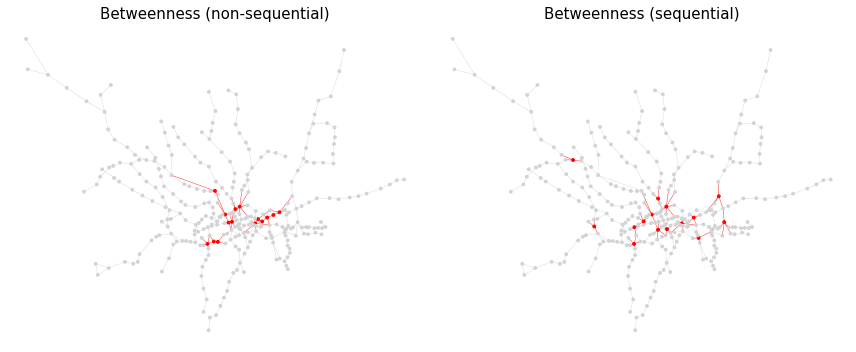

In [13]:
# betweenness_network_UnSeq_VS_Seq.png
node_color=[]
edge_color = []
for node in g_shp_un.nodes(data = True):
    if node[0] in list_between1[0:15]:
        node_color.append('red')
    else:
        node_color.append('lightgrey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(list_between1[0:15]):
        edge_color.append('red')
    else:
        edge_color.append('lightgrey')

#add edges linking nodes:


node_color1=[]
edge_color1 = []
for node in g_shp_un.nodes(data = True):
    if node[0] in between_node:
        node_color1.append('red')
    else:
        node_color1.append('lightgrey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(between_node):
        edge_color1.append('red')
    else:
        edge_color1.append('lightgrey')

#add edges linking nodes:

pos={e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

fig, axes = plt.subplots(1, 2,figsize=(12,5))
ax = axes.flatten()
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color, 
        width=0.4,ax=ax[0])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color,
        node_size= 8,ax=ax[0])


ax[0].set_axis_off()
ax[0].set_title("Betweenness (non-sequential)",fontsize=15)
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color1, 
        width=0.4,ax=ax[1])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color1,
        node_size= 8,ax=ax[1])

ax[1].set_axis_off()
ax[1].set_title("Betweenness (sequential)",fontsize=15)
fig.tight_layout()
plt.savefig('2.1.betweenness_network_UnSeq_VS_Seq.png')

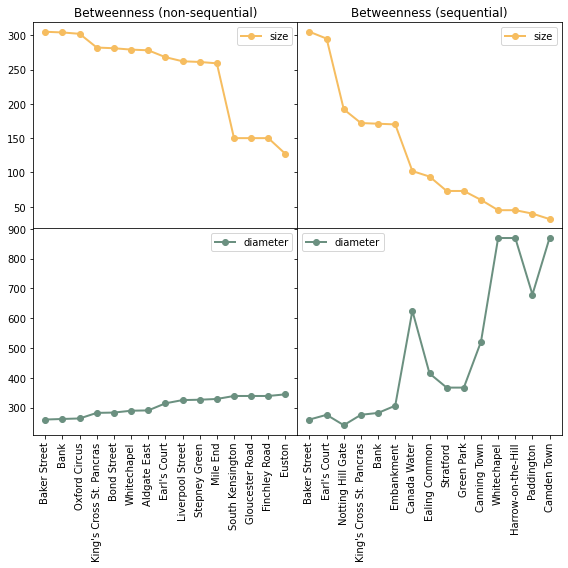

In [14]:
# betweenness_Size_D_UnSeq_VS_Seq.png
fig= plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax3), (ax2, ax4) = gs.subplots(sharex='col',sharey='row')
# multiple line plots
ax1.plot( 'station', 'size', data=between_unse, marker='o', color='#f6bd60', linewidth=2)
ax2.plot( 'station', 'diameter', data=between_unse, marker='o',color='#6b9080', linewidth=2)

# show legend
ax1.legend()
ax2.legend()

ax2.tick_params('x', labelrotation=90)
ax1.set_title('Betweenness (non-sequential)')

# multiple line plots
ax3.plot( 'station', 'size', data=between_se, marker='o', color='#f6bd60', linewidth=2)
ax4.plot( 'station', 'diameter', data=between_se, marker='o', color='#6b9080', linewidth=2)
ax3.legend()
ax4.legend()
ax4.tick_params('x', labelrotation=90)
ax3.set_title('Betweenness (sequential)')





# show graph
fig.tight_layout()
plt.savefig('2.2.betweenness_Size_D_UnSeq_VS_Seq.png')

In [15]:
# station_between_list & csv
station_between_seq = pd.DataFrame()

station_between_seq = between_unse[['station','degree','size','diameter']]

station_between_seq = between_se[['station','degree','size','diameter']]

station_between_seq.to_csv('2.3.result.csv')
station_between_seq

,station,degree,size,diameter
0,Baker Street,2.268852,305,260.109150
1,Earl's Court,2.236842,295,275.938886
2,Notting Hill Gate,2.217822,192,241.158475
3,King's Cross St. Pancras,2.178808,172,276.032176
4,Bank,2.146179,171,282.299658
5,Embankment,2.126667,170,306.578181
6,Canada Water,2.107023,102,625.160975
7,Ealing Common,2.093960,94,414.743002
8,Stratford,2.074074,73,367.274325
9,Green Park,2.040541,73,367.274325


### Closeness

In [16]:
#closeness unseq
#########################################################
##Lets compute weighted closeness
clos=nx.closeness_centrality(g_shp_un, distance='distance')

# Let us add the closeness centrality as attribute to the nodes in the graph
nx.set_node_attributes(g_shp_un,clos,'closeness')
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['closeness'],reverse=True))

list_clos = list(listbet_un.items())[:15]


# Lets set colour and size of nodes according to betweenness values
clos_w_values=[(i[1]['closeness']) for i in g_shp_un.nodes(data=True)]

clos_w_color=[(i[1]['closeness']/max(clos_w_values)) for i in g_shp_un.nodes(data=True)]
clos_w_size=[(i[1]['closeness']/max(clos_w_values)*100) for i in g_shp_un.nodes(data=True)]

list_clos1 = []
list_clos1_station = []

for i in list_clos:
    list_clos1.append(i[0])
    list_clos1_station.append(i[1].get('station'))

clos_unse_trend = []

clos_unse_path = []
clos_unse_diameter = []
clos_unse_path_norm = []
clos_unse_diameter_norm = []
clos_unse_cluster = []
clos_unse_aver_deg =[]
G = copy.deepcopy(g_shp_un)
G = copy.deepcopy(g_shp_un)
for i in range(0,15):
    G.remove_node(list_clos1[i])
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    clos_unse_trend.append(len(G0))
    degrees = [val for (node, val) in G.degree()]
    clos_unse_aver_deg.append(sum(degrees)/len(degrees))
    clos_unse_path.append(nx.average_shortest_path_length(G0,weight='distance'))
    clos_unse_path_norm.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    clos_unse_diameter.append(d)
    clos_unse_diameter_norm.append(d/len(G0))
    clos_unse_cluster.append(nx.average_clustering(G))

clos_unse = pd.DataFrame({'station':list_clos1_station[0:15],'size':clos_unse_trend,'degree':clos_unse_aver_deg,'diameter':clos_unse_diameter_norm})

In [17]:
#closeness seq
#########################################################
clos_station = []
clos_trend = []
clos_node = []
clos_path = []
clos_diameter = []
clos_path_norm = []
clos_diameter_norm = []
clos_cluster = []
clos_aver_deg =[]
G = copy.deepcopy(g_shp_un)

for i in range(0,15):

    clos=nx.closeness_centrality(G, distance='distance')
    nx.set_node_attributes(G,clos,'closeness')
    dict_un=dict(G.nodes(data=True))

    clos_node.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['closeness'],reverse=True)).items())[0][0])
    clos_station.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['closeness'],reverse=True)).items())[0][1].get('station'))
    G.remove_node(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['closeness'],reverse=True)).items())[0][0])
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    degrees = [val for (node, val) in G.degree()]
    clos_aver_deg.append(sum(degrees)/len(degrees))
    clos_trend.append(len(G0))
    clos_path.append(nx.average_shortest_path_length(G0,weight='distance'))
    clos_path_norm.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    clos_diameter.append(d)
    clos_diameter_norm.append(d/len(G0))
    clos_cluster.append(nx.average_clustering(G))

clos_se = pd.DataFrame({'station':clos_station[0:15] ,'size':clos_trend,'degree':clos_aver_deg,'diameter':clos_diameter_norm,'clus':clos_cluster})

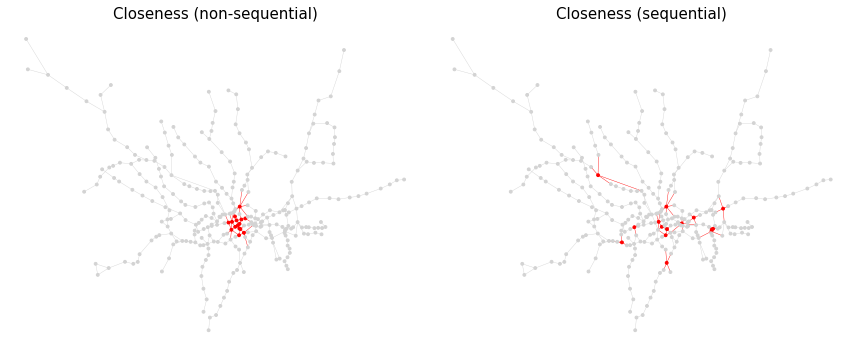

In [18]:
# closeness_network_UnSeq_VS_Seq.png
node_color=[]
edge_color = []
for node in g_shp_un.nodes(data = True):
    if node[0] in list_clos1[0:15]:
        node_color.append('red')
    else:
        node_color.append('lightgrey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(list_clos1[0:15]):
        edge_color.append('red')
    else:
        edge_color.append('lightgrey')

#add edges linking nodes:


node_color1=[]
edge_color1 = []
for node in g_shp_un.nodes(data = True):
    if node[0] in clos_node:
        node_color1.append('red')
    else:
        node_color1.append('lightgrey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(clos_node):
        edge_color1.append('red')
    else:
        edge_color1.append('lightgrey')

#add edges linking nodes:

pos={e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

fig, axes = plt.subplots(1, 2,figsize=(12,5))
ax = axes.flatten()
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color, 
        width=0.4,ax=ax[0])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color,
        node_size= 8,ax=ax[0])


ax[0].set_axis_off()
ax[0].set_title("Closeness (non-sequential)",fontsize=15)
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color1, 
        width=0.4,ax=ax[1])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color1,
        node_size= 8,ax=ax[1])

ax[1].set_axis_off()
ax[1].set_title("Closeness (sequential)",fontsize=15)
fig.tight_layout()
plt.savefig('3.1.closeness_network_UnSeq_VS_Seq.png')

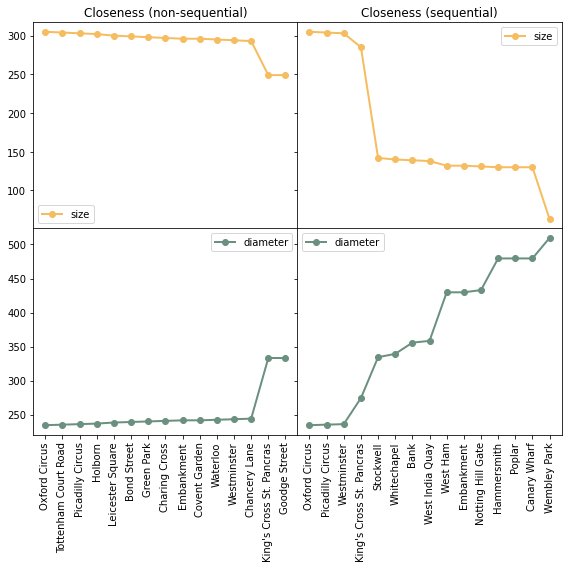

In [19]:
# closeness_Size_D_UnSeq_VS_Seq.png

fig= plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax3), (ax2, ax4) = gs.subplots(sharex='col',sharey='row')
# multiple line plots
ax1.plot( 'station', 'size', data=clos_unse, marker='o', color='#f6bd60', linewidth=2)
ax2.plot( 'station', 'diameter', data=clos_unse, marker='o',color='#6b9080', linewidth=2)

# show legend
ax1.legend()
ax2.legend()

ax2.tick_params('x', labelrotation=90)
ax1.set_title('Closeness (non-sequential)')
# multiple line plots
ax3.plot( 'station', 'size', data=clos_se, marker='o', color='#f6bd60', linewidth=2)
ax4.plot( 'station', 'diameter', data=clos_se, marker='o', color='#6b9080', linewidth=2)
ax3.legend()
ax4.legend()
ax4.tick_params('x', labelrotation=90)
ax3.set_title('Closeness (sequential)')
# show graph
fig.tight_layout()
plt.savefig('3.2.closeness_Size_D_UnSeq_VS_Seq.png')

In [20]:
# station_between_list & csv
station_close_seq = pd.DataFrame()
station_close_seq = clos_se[['station','degree','size','diameter']]
station_close_seq.to_csv('3.3.result.csv')
station_close_seq

,station,degree,size,diameter
0,Oxford Circus,2.275410,305,234.397111
1,Picadilly Circus,2.263158,304,235.168154
2,Westminster,2.244224,303,235.944286
3,King's Cross St. Pancras,2.205298,285,274.265648
4,Stockwell,2.186047,142,334.348833
5,Whitechapel,2.166667,140,339.224946
6,Bank,2.133779,139,355.739485
7,West India Quay,2.120805,138,358.317307
8,West Ham,2.101010,132,429.706373
9,Embankment,2.087838,132,429.706373


## Comparison

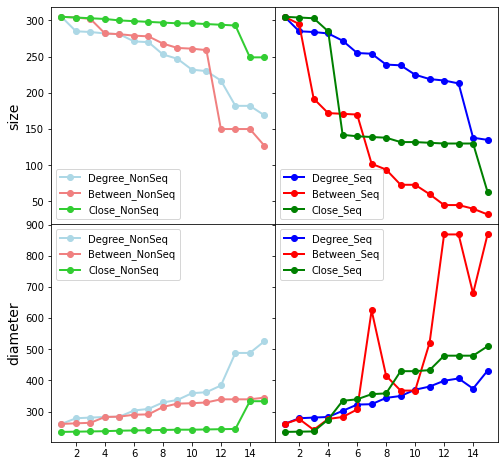

In [21]:
# Comparison png

from matplotlib.ticker import MaxNLocator
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
fig= plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

ax1.plot(x,'size',data=degree_unse,marker='o',  color='lightblue', linewidth=2,label = 'Degree_NonSeq')
ax1.plot(x,'size',data=between_unse,marker='o', color='lightcoral', linewidth=2,label = 'Between_NonSeq')
ax1.plot(x,'size',data=clos_unse,marker='o', color='limegreen', linewidth=2,label = 'Close_NonSeq')
ax2.plot(x,'size',data=degree_se,marker='o', color='blue', linewidth=2,label = 'Degree_Seq')
ax2.plot(x,'size',data=between_se,marker='o', color='red', linewidth=2,label = 'Between_Seq')
ax2.plot(x,'size',data=clos_se,marker='o', color='green', linewidth=2,label = 'Close_Seq')
ax1.set_ylabel('size',size = 14)

ax1.legend()
ax2.legend(loc = 'lower left')

ax3.plot(x,'diameter',data=degree_unse,marker='o',color='lightblue', linewidth=2,label = 'Degree_NonSeq')
ax3.plot(x,'diameter',data=between_unse,marker='o', color='lightcoral', linewidth=2,label = 'Between_NonSeq')
ax3.plot(x,'diameter',data=clos_unse,marker='o', color='limegreen', linewidth=2,label = 'Close_NonSeq')
ax4.plot(x,'diameter',data=degree_se,marker='o', color='blue', linewidth=2,label = 'Degree_Seq')
ax4.plot(x,'diameter',data=between_se,marker='o', color='red', linewidth=2,label = 'Between_Seq')
ax4.plot(x,'diameter',data=clos_se,marker='o', color='green', linewidth=2,label = 'Close_Seq')
ax3.set_ylabel('diameter',size = 14)
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('4.Comparison.png')

---

---

---

# Part 2

In [22]:
# Read Origin-Destination table from the csv
orig_dest = pd.read_csv('ODtube2017.csv')

#Later when using the Commuters data we will have an issue mapping node 'Heathrow Terminals 1, 2 & 3', 
#so we are going to rename it here:
#1. find the node 'Heathrow Terminals 1, 2 & 3'
nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]
#2.Rename it with the name given by the the commuters file (see later):
g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

#This can be seen as a network by itself:
g_OD = nx.from_pandas_edgelist(orig_dest, 'station_name', 'station_name.1',['total_wtrips'],create_using = nx.DiGraph)

#Change the names of nodes by the id in g_shp_un (tube network):
#1.Copy name as an attribute:
nod_names={(e1):e1 for e1 in g_OD.nodes()}
nx.set_node_attributes(g_OD,nod_names,'station') #with nod_id1 or nod_id2 is enought
#2.Do the mapping with id in g_shp_un
mapping = {g_shp_un.nodes[i]['station']:i for i in g_shp_un.nodes()}
g_OD = nx.relabel_nodes(g_OD, mapping)

#and we can add coodenates to the nodes, from the shapefile of the tube network:
nod_coords={(e1):coord for e1, coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_OD,nod_coords,'station_coord') #with nod_id1 or nod_id2 is enought
pos = {e1: xy for e1,xy in g_OD.nodes(data='station_coord')}

## Section1

### previous

In [23]:
# adj 1
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
adj_c=np.zeros((N, N))

#Fill the adjacency matrix with Origin-Destination flows:
#From origin to destination with x commuters, we will compute the shortest path and fill the number of commuters
#for each pair of stations they go through:
for e1,e2,C in g_OD.edges(data='total_wtrips'):
    path = nx.dijkstra_path(g_shp_un,e1,e2)  
    #shortest path e1,e2 taking into account distance weights in g_shp_un
    
    path_edges = list(zip(path,path[1:])) 
    #list of tuples with shortest path edges [(e1,s2),(s3,s4),...,(s(n-1),e2)]
    
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C 
            #sum the contribution of the OD flow to all edges in the shortest path
adj_c

array([[    0., 15400., 36470., ...,     0.,     0.,     0.],
       [15035.,     0.,     0., ...,     0.,     0.,     0.],
       [19675.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [24]:
#Create the new graph from the adjancency matrix:
g_flows=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph)

#we need to give coordinates to these nodes too:
nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_flows,nod_coord,'station_coord')

#also the station names:
nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(g_flows,nod_names,'station')

# Lets set colour and size of nodes according to the flows_
weights={(e1, e2):round(1./w,7) for e1, e2, w in g_flows.edges(data='weight')}
# Let us add the inverted weight as an attribute to the edges in the graph
nx.set_edge_attributes(g_flows, weights, 'weights')

# To check an specific edge data attribute:
N=len(g_shp_un.nodes()) #As we are going to use shortest path in the tube network, N is from g_shp_un
flow=np.zeros((N, N))
for e1,e2,C in g_OD.edges(data='total_wtrips'):
    flow[e1,e2] = g_OD.edges[e1,e2]['total_wtrips']

In [25]:
# pop and job
pop = np.sum(flow, axis=1) 
job = np.sum(flow, axis=0) 
pop = {v: k for v, k in enumerate(pop)}
job = {v: k for v, k in enumerate(job)}
nx.set_node_attributes(g_flows,pop,'pop') 
nx.set_node_attributes(g_flows,job,'job') 

sum = 0
for i in range(N):
    sum = sum + flow[i,2]

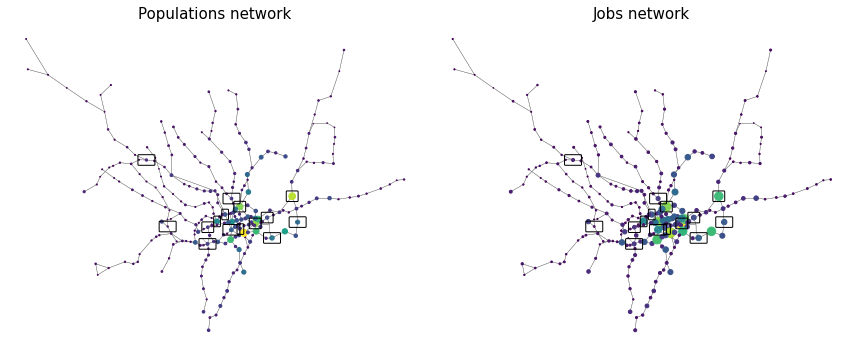

In [26]:
# plot pop and job follow part 1


##########################
#pop
##########################


node_values=[(i[1]['pop']) for i in g_flows.nodes(data=True)]
node_color=[i[1]['pop']/max(node_values) for i in g_flows.nodes(data=True)]
node_size=[i[1]['pop']/max(node_values)*50 for i in g_flows.nodes(data=True)]

# Plot graph
#pos_shp = {xy: xy for xy in g_shp.nodes()}
pos={e1: xy for e1,xy in g_flows.nodes(data='station_coord')}


fig, axes = plt.subplots(1, 2,figsize=(12,5))
ax = axes.flatten()

nx.draw_networkx_edges(g_flows, pos,edge_color='gray', 
        width=0.4,arrows = False,ax=ax[0])
nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= node_color,
        node_size= node_size,ax=ax[0])
subnodelist = between_node
labels = {k:k for k in subnodelist}    

nx.draw_networkx_labels(g_flows, pos, labels = labels,font_size=8,font_color = 'white',alpha = 0.1,bbox=dict(facecolor="none", edgecolor='black', boxstyle='round,pad=0.1'),ax=ax[0])


ax[0].set_axis_off()
ax[0].set_title("Populations network",fontsize=15)


##########################
#job
##########################

node_values1=[(i[1]['job']) for i in g_flows.nodes(data=True)]
node_color1=[i[1]['job']/max(node_values)*100 for i in g_flows.nodes(data=True)]
node_size1=[i[1]['job']/max(node_values)*100 for i in g_flows.nodes(data=True)]



nx.draw_networkx_edges(g_flows, pos,edge_color='gray', 
        width=0.4,arrows = False,ax=ax[1])
nx.draw_networkx_nodes(g_flows,
        pos = pos,
        node_color= node_color1,
        node_size= node_size1,ax=ax[1])
subnodelist1 = between_node
labels1 = {k:k for k in subnodelist1}    

nx.draw_networkx_labels(g_flows, pos, labels = labels1,font_size=8,font_color = 'white',alpha = 0.1,bbox=dict(facecolor="none", edgecolor='black', boxstyle='round,pad=0.1'),ax=ax[1])


ax[1].set_axis_off()
ax[1].set_title("Jobs network",fontsize=15)
# show graph
fig.tight_layout()

plt.savefig('5.1.popjob.png')

<Figure size 576x576 with 0 Axes>

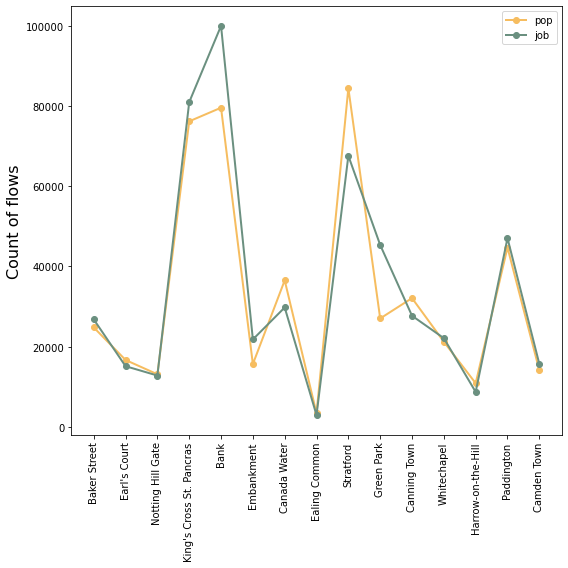

In [27]:
# plot line
fig= plt.figure(figsize=(8,8))

population = []
job_be = []
for i in between_node:
    population.append(g_flows.nodes[i]['pop'])
    job_be.append(g_flows.nodes[i]['job'])

between_se = pd.DataFrame({'station':between_station[0:15] ,'size': between_trend,'degree':between_aver_deg,'diameter': between_diameter_norm,'pop':population,'job':job_be})

fig= plt.figure(figsize=(8,8))

plt.plot( 'station', 'pop', data=between_se, marker='o', color='#f6bd60', linewidth=2)
plt.plot( 'station', 'job', data=between_se, marker='o',color='#6b9080', linewidth=2)

plt.ylabel('Count of flows',size = 16)

# show legend
plt.legend()
plt.tick_params('x', labelrotation=90)
fig.tight_layout()
plt.savefig('5.2.popjob_line.png')

### degree

In [28]:
# degree in flow
############################################
degree_station_flow = []
degree_trend_flow = []
degree_node_flow = []
degree_path_flow = []
degree_diameter_flow = []
degree_path_norm_flow = []
degree_diameter_norm_flow = []
degree_cluster_flow = []
degree_aver_deg_flow =[]
G = copy.deepcopy(g_flows)
for i in range(0,15):
    
    in_deg_centrality = nx.in_degree_centrality(G)
   
    nx.set_node_attributes(G,dict(in_deg_centrality),'in_degree_norm')
    dict_un=dict(G.nodes(data=True))
    
    degree_station_flow.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['in_degree_norm'],reverse=True)).items())[0][1].get('station'))
    degree_node_flow.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['in_degree_norm'],reverse=True)).items())[0][0])
    G.remove_node(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['in_degree_norm'],reverse=True)).items())[0][0])
    Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    degrees = [val for (node, val) in G.degree()]
    degree_trend_flow.append(len(G0))
    degree_path_flow.append(nx.average_shortest_path_length(G0,weight='distance'))
    degree_path_norm_flow.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    degree_diameter_flow.append(d)
    degree_diameter_norm_flow.append(d/len(G0))
    degree_cluster_flow.append(nx.average_clustering(G))

    
############################################
degree_se_inflow = pd.DataFrame({'station':degree_station_flow[0:15] ,'size': degree_trend_flow,'diameter': degree_diameter_norm_flow})

In [29]:
# degree out flow

degree_station_flow1 = []
degree_trend_flow1 = []
degree_node_flow1 = []
degree_path_flow1 = []
degree_diameter_flow1 = []
degree_path_norm_flow1 = []
degree_diameter_norm_flow1 = []
degree_cluster_flow1 = []
degree_aver_deg_flow1 =[]
G = copy.deepcopy(g_flows)
for i in range(0,15):
    
    out_deg_centrality = nx.out_degree_centrality(G)
   
    nx.set_node_attributes(G,dict(out_deg_centrality),'out_degree_norm')
    dict_un=dict(G.nodes(data=True))
    
    degree_station_flow1.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['out_degree_norm'],reverse=True)).items())[0][1].get('station'))
    degree_node_flow1.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['out_degree_norm'],reverse=True)).items())[0][0])
    G.remove_node(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['out_degree_norm'],reverse=True)).items())[0][0])
    Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    degrees = [val for (node, val) in G.degree()]
    degree_trend_flow1.append(len(G0))
    degree_path_flow1.append(nx.average_shortest_path_length(G0,weight='distance'))
    degree_path_norm_flow1.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    degree_diameter_flow1.append(d)
    degree_diameter_norm_flow1.append(d/len(G0))
    degree_cluster_flow1.append(nx.average_clustering(G))

degree_se_outflow = pd.DataFrame({'station':degree_station_flow1[0:15] ,'size': degree_trend_flow1,'diameter': degree_diameter_norm_flow1})

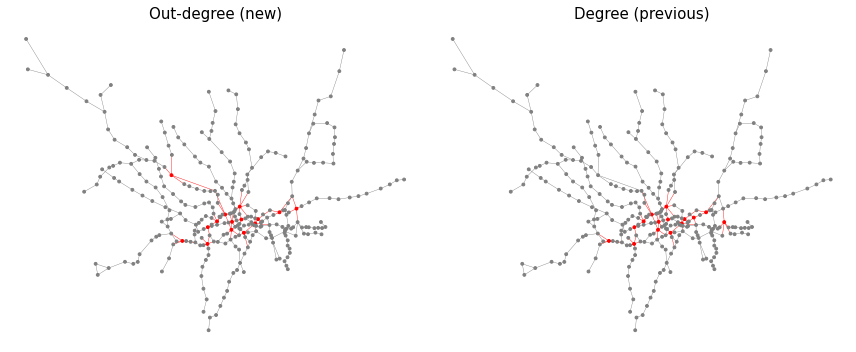

In [30]:
# degree plot

node_color=[]
edge_color = []
for node in g_shp_un.nodes(data = True):
    if node[0] in degree_node_flow:
        node_color.append('red')
    else:
        node_color.append('grey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(degree_node_flow):
        edge_color.append('red')
    else:
        edge_color.append('grey')

#add edges linking nodes:



node_color1=[]
edge_color1 = []
for node in g_shp_un.nodes(data = True):
    if node[0] in degree_node:
        node_color1.append('red')
    else:
        node_color1.append('grey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(degree_node):
        edge_color1.append('red')
    else:
        edge_color1.append('grey')

#add edges linking nodes:

pos={e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

fig, axes = plt.subplots(1, 2,figsize=(12,5))
ax = axes.flatten()
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color, 
        width=0.4,ax=ax[0])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color,
        node_size= 8,ax=ax[0])


ax[0].set_axis_off()
ax[0].set_title("Out-degree (new)",fontsize=15)
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color1, 
        width=0.4,ax=ax[1])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color1,
        node_size= 8,ax=ax[1])

ax[1].set_axis_off()
ax[1].set_title("Degree (previous)",fontsize=15)
fig.tight_layout()
plt.savefig('6.1.degree.png')

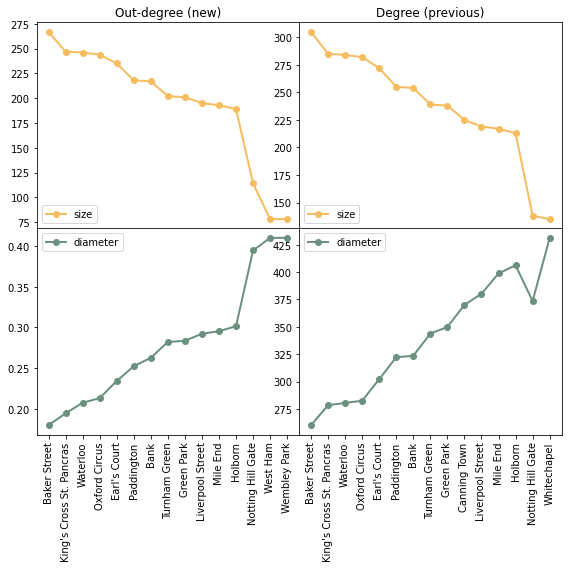

In [31]:
# degree line graph
fig= plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax3), (ax2, ax4) = gs.subplots(sharex='col')
# multiple line plots
ax1.plot( 'station', 'size', data=degree_se_outflow, marker='o', color='#f6bd60', linewidth=2)
ax2.plot( 'station', 'diameter', data=degree_se_outflow, marker='o',color='#6b9080', linewidth=2)

# show legend
ax1.legend(loc='lower left')
ax2.legend(loc='upper left')

ax2.tick_params('x', labelrotation=90)
ax1.set_title('Out-degree (new)')

ax3.plot( 'station', 'size', data=degree_se, marker='o', color='#f6bd60', linewidth=2)
ax4.plot( 'station', 'diameter', data=degree_se, marker='o', color='#6b9080', linewidth=2)
ax3.legend(loc='lower left')
ax4.legend(loc='upper left')
ax4.tick_params('x', labelrotation=90)
ax3.set_title('Degree (previous)')
# show graph
fig.tight_layout()
plt.savefig('6.2.degree_line.png')

### betweenness

In [32]:
# between

between_station_flow = []
between_trend_flow = []
between_node_flow = []
between_path_flow = []
between_diameter_flow = []
between_path_norm_flow = []
between_diameter_norm_flow = []
between_cluster_flow = []
between_aver_deg_flow =[]
G = copy.deepcopy(g_flows)
for i in range(0,15):

    bet_london_w=nx.betweenness_centrality(G, weight='weights', normalized=False)
    nx.set_node_attributes(G,bet_london_w,'betweenness_un')
    dict_un=dict(G.nodes(data=True))
    
    between_node_flow.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True)).items())[0][0])
    between_station_flow.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True)).items())[0][1].get('station'))
    G.remove_node(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True)).items())[0][0])
    Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    degrees = [val for (node, val) in G.degree()]

    between_trend_flow.append(len(G0))
    between_path_flow.append(nx.average_shortest_path_length(G0,weight='distance'))
    between_path_norm_flow.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    between_diameter_flow.append(d)
    between_diameter_norm_flow.append(d/len(G0))
    between_cluster_flow.append(nx.average_clustering(G))
    
between_se_flow = pd.DataFrame({'station':between_station_flow[0:15] ,'size': between_trend_flow,'diameter': between_diameter_norm_flow})

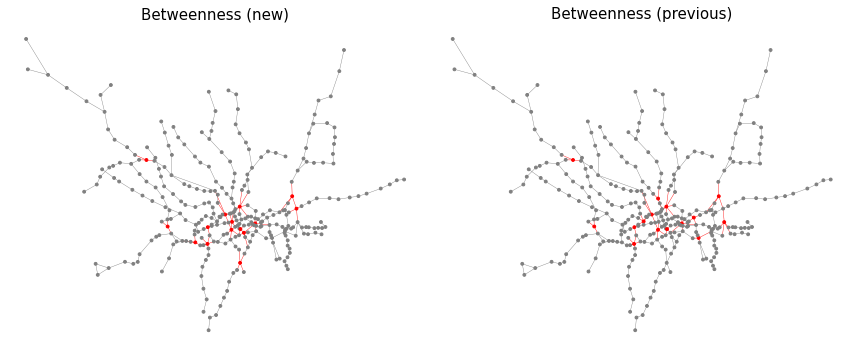

In [33]:
# between plot

node_color=[]
edge_color = []
for node in g_shp_un.nodes(data = True):
    if node[0] in between_node_flow:
        node_color.append('red')
    else:
        node_color.append('grey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(between_node_flow):
        edge_color.append('red')
    else:
        edge_color.append('grey')

#add edges linking nodes:



node_color1=[]
edge_color1 = []
for node in g_shp_un.nodes(data = True):
    if node[0] in between_node:
        node_color1.append('red')
    else:
        node_color1.append('grey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(between_node):
        edge_color1.append('red')
    else:
        edge_color1.append('grey')

#add edges linking nodes:

pos={e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

fig, axes = plt.subplots(1, 2,figsize=(12,5))
ax = axes.flatten()
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color, 
        width=0.4,ax=ax[0])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color,
        node_size= 8,ax=ax[0])


ax[0].set_axis_off()
ax[0].set_title("Betweenness (new)",fontsize=15)
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color1, 
        width=0.4,ax=ax[1])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color1,
        node_size= 8,ax=ax[1])

ax[1].set_axis_off()
ax[1].set_title("Betweenness (previous)",fontsize=15)
fig.tight_layout()
plt.savefig('7.1.between.png')

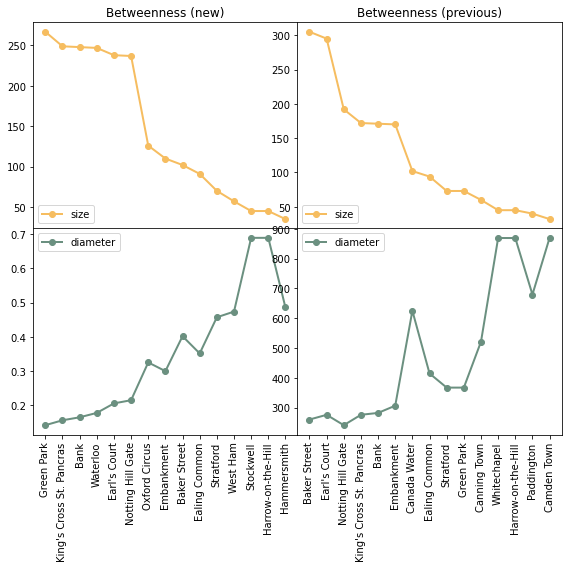

In [34]:
# between line plot

fig= plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax3), (ax2, ax4) = gs.subplots(sharex='col')
# multiple line plots
ax1.plot( 'station', 'size', data=between_se_flow, marker='o',  color='#f6bd60', linewidth=2)
ax2.plot( 'station', 'diameter', data=between_se_flow, marker='o',color='#6b9080', linewidth=2)

# show legend
ax1.legend(loc='lower left')
ax2.legend(loc='upper left')

ax2.tick_params('x', labelrotation=90)
ax1.set_title('Betweenness (new)')

ax3.plot( 'station', 'size', data=between_se, marker='o',  color='#f6bd60', linewidth=2)
ax4.plot( 'station', 'diameter', data=between_se, marker='o', color='#6b9080', linewidth=2)
ax3.legend(loc='lower left')
ax4.legend(loc='upper left')
ax4.tick_params('x', labelrotation=90)
ax3.set_title('Betweenness (previous)')
# show graph
fig.tight_layout()
plt.savefig('7.2.between_line.png')

### closeness

In [35]:
# close

clos_station_flow = []
clos_trend_flow = []
clos_node_flow = []
clos_path_flow = []
clos_diameter_flow = []
clos_path_norm_flow = []
clos_diameter_norm_flow = []
clos_cluster_flow = []
clos_aver_deg_flow =[]
G = copy.deepcopy(g_flows)

for i in range(0,15):
    clos=nx.closeness_centrality(G, distance='weights')
    nx.set_node_attributes(G,clos,'closeness')
    dict_un=dict(G.nodes(data=True))
    
    clos_node_flow.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['closeness'],reverse=True)).items())[0][0])
    clos_station_flow.append(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['closeness'],reverse=True)).items())[0][1].get('station'))
    G.remove_node(list(OrderedDict(sorted(dict_un.items(), key=lambda x: x[1]['closeness'],reverse=True)).items())[0][0])
    Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    degrees = [val for (node, val) in G.degree()]

    clos_trend_flow.append(len(G0))
    clos_path_flow.append(nx.average_shortest_path_length(G0,weight='distance'))
    clos_path_norm_flow.append(nx.average_shortest_path_length(G0,weight='distance')/len(G0))
    nlen = {n:nx.single_source_dijkstra_path_length(G0, n, weight='distance') for n in G0.nodes() }
    e = nx.eccentricity(G0,sp=nlen)
    d = nx.diameter(G0, e)
    clos_diameter_flow.append(d)
    clos_diameter_norm_flow.append(d/len(G0))
    clos_cluster_flow.append(nx.average_clustering(G))
    
clos_se_flow = pd.DataFrame({'station':clos_station_flow[0:15],'size':clos_trend_flow,'diameter':clos_diameter_norm_flow})

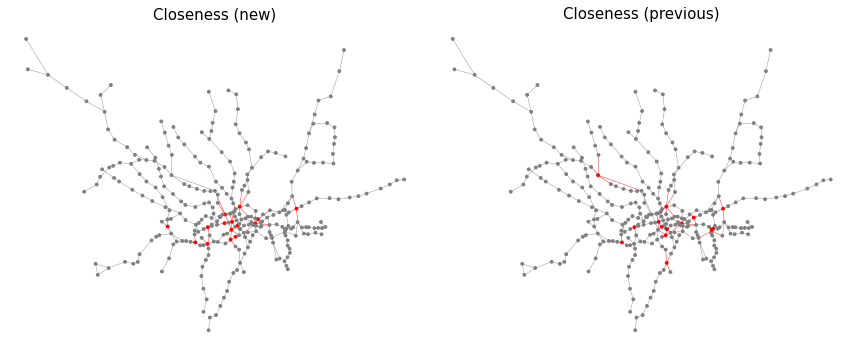

In [36]:
# close plot

node_color=[]
edge_color = []
for node in g_shp_un.nodes(data = True):
    if node[0] in clos_node_flow:
        node_color.append('red')
    else:
        node_color.append('grey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(clos_node_flow):
        edge_color.append('red')
    else:
        edge_color.append('grey')

#add edges linking nodes:



node_color1=[]
edge_color1 = []
for node in g_shp_un.nodes(data = True):
    if node[0] in clos_node:
        node_color1.append('red')
    else:
        node_color1.append('grey')
for edge in g_shp_un.edges:
    if edge in g_shp_un.edges(clos_node):
        edge_color1.append('red')
    else:
        edge_color1.append('grey')

#add edges linking nodes:

pos={e1: xy for e1,xy in g_shp_un.nodes(data='station_coord')}

fig, axes = plt.subplots(1, 2,figsize=(12,5))
ax = axes.flatten()
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color, 
        width=0.4,ax=ax[0])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color,
        node_size= 8,ax=ax[0])


ax[0].set_axis_off()
ax[0].set_title("Closeness (new)",fontsize=15)
nx.draw_networkx_edges(g_shp_un, pos,edge_color=edge_color1, 
        width=0.4,ax=ax[1])
nx.draw_networkx_nodes(g_shp_un,
        pos = pos,
        node_color= node_color1,
        node_size= 8,ax=ax[1])

ax[1].set_axis_off()
ax[1].set_title("Closeness (previous)",fontsize=15)
fig.tight_layout()
plt.savefig('8.1.close.png')

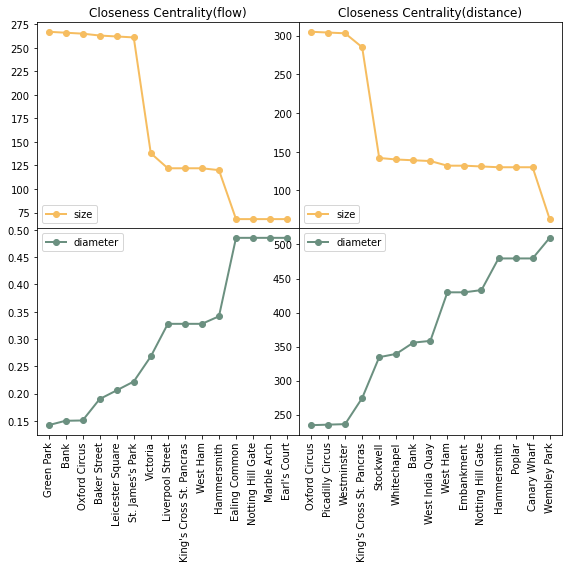

In [37]:
# close line graph


fig= plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax3), (ax2, ax4) = gs.subplots(sharex='col')
# multiple line plots
ax1.plot( 'station', 'size', data=clos_se_flow, marker='o', color='#f6bd60', linewidth=2)
ax2.plot( 'station', 'diameter', data=clos_se_flow, marker='o',color='#6b9080', linewidth=2)

# show legend
ax1.legend(loc='lower left')
ax2.legend(loc='upper left')

ax2.tick_params('x', labelrotation=90)
ax1.set_title('Closeness Centrality(flow)')

# multiple line plots
ax3.plot( 'station', 'size', data=clos_se, marker='o',  color='#f6bd60', linewidth=2)
ax4.plot( 'station', 'diameter', data=clos_se, marker='o', color='#6b9080', linewidth=2)

# legend
ax3.legend(loc='lower left')
ax4.legend(loc='upper left')

ax4.tick_params('x', labelrotation=90)
ax3.set_title('Closeness Centrality(distance)')
# show graph
fig.tight_layout()
plt.savefig('8.2.close_line.png')


## Section 2

In [4]:
df = pd.read_csv('data.csv')  

In [7]:
df

,ori_station,des_station,total_trips,distance,log_dis,ori_pop,des_jobs,log_ori_pop,doubsim_form,double_B1,SB1,double_B2,double_B3
0,Acton Town,Alperton,143,4785.556297,8.473358,5910.0,2961.0,8.684401,59.0,60.0,1.0,81.0,92.0
1,Acton Town,Amersham,22,36052.719259,10.492738,5910.0,1384.0,8.684401,4.0,4.0,0.0,1.0,0.0
2,Acton Town,Angel,15,14868.355669,9.606990,5910.0,17683.0,8.684401,30.0,30.0,0.0,22.0,18.0
3,Acton Town,Archway,9,17188.348797,9.751987,5910.0,7388.0,8.684401,16.0,16.0,0.0,11.0,9.0
4,Acton Town,Arsenal,9,17036.911892,9.743138,5910.0,1857.0,8.684401,5.0,4.0,-1.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33966,Upminster Bridge,Waterloo,29,25649.880704,10.152294,1482.0,87309.0,7.301148,42.0,41.0,-1.0,21.0,13.0
33967,Upminster Bridge,West Brompton,2,32282.729666,10.382288,1482.0,4854.0,7.301148,2.0,2.0,0.0,1.0,0.0
33968,Upminster Bridge,West Ham,24,16391.363195,9.704510,1482.0,13975.0,7.301148,30.0,30.0,0.0,25.0,20.0
33969,Upminster Bridge,Westminster,1,26473.126971,10.183885,1482.0,24164.0,7.301148,11.0,10.0,-1.0,5.0,3.0


In [5]:
# pop job dataset

nx.set_node_attributes(g_OD,pop,'pop') 
nx.set_node_attributes(g_OD,job,'job') 

for e1,e2,C in g_OD.edges(data=True):
    g_OD[e1][e2].update({'ori_pop':g_OD.nodes[e1]['pop']}) 
    g_OD[e1][e2].update({'des_job':g_OD.nodes[e2]['job']}) 
    
for e1,e2,C in g_flows.edges(data=True):
    g_flows[e1][e2].update({'ori_pop':g_flows.nodes[e1]['pop']}) 
    g_flows[e1][e2].update({'des_job':g_flows.nodes[e2]['job']}) 

for e1,e2,C in g_OD.edges(data=True):
    g_OD[e1][e2].update({'ori_station':g_OD.nodes[e1]['station']}) 
    g_OD[e1][e2].update({'des_station':g_OD.nodes[e2]['station']}) 
    
for e1,e2,C in g_OD.edges(data=True):
    try:
        g_flows[e1][e2].update({'flows':g_OD[e1][e2]['total_wtrips']})
        
    except KeyError:
        continue

NameError: name 'g_OD' is not defined

In [39]:
# update adj

def Reverse(tuples):
    new_tup = tuples[::-1]
    return new_tup

import geopy.distance

for e1,e2,C in g_flows.edges(data=True):
    g_flows[e1][e2].update({'distance':geopy.distance.GeodesicDistance(Reverse(g_flows.nodes[e1]['station_coord']),
                                                                       Reverse(g_flows.nodes[e2]['station_coord'])).m}) 

import geopy.distance

for e1,e2,C in g_OD.edges(data=True):
    g_OD[e1][e2].update({'true_distance':nx.dijkstra_path_length(g_flows,e1,e2,weight='distance')}) 



In [6]:
# R2 and RMSE

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [41]:
# final dataset
ori_station = []
des_station = []
total_trips = []
distance = []
ori_pop = []
des_jobs = []

for e1,e2,C in g_OD.edges(data=True):
    ori_station.append(g_OD[e1][e2]['ori_station'])
    des_station.append(g_OD[e1][e2]['des_station'])
    ori_pop.append(g_OD[e1][e2]['ori_pop'])
    des_jobs.append(g_OD[e1][e2]['des_job'])
    distance.append(g_OD[e1][e2]['true_distance'])
    total_trips.append(g_OD[e1][e2]['total_wtrips'])
    
# finalfinal dataset
log_dis = np.log(distance)
log_ori_pop = np.log(ori_pop)

d = {'ori_station': ori_station, 
     'des_station': des_station,
     'total_trips':total_trips,
     'distance':distance,'log_dis':log_dis,
     'ori_pop':ori_pop,
     'des_jobs':des_jobs,'log_ori_pop':log_ori_pop}

df = pd.DataFrame(data=d)

cdatasubmat = pd.pivot_table(df, values ="total_trips", index="ori_station", columns = "des_station",
                             aggfunc=np.sum, margins=True)

### inverse power law

In [42]:
# power law

#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'total_trips ~ des_station + ori_station + log_dis-1'
#run a production constrained sim
doubSim = smf.glm(formula = dbl_form, data=df, family=sm.families.Poisson()).fit()

In [43]:
# power law matrix ### cdatasubmat8

#get the estimates
df["doubsimfitted"] = np.round(doubSim.predict())

#here's the matrix
cdatasubmat8 = df.pivot_table(values ="doubsimfitted", index="ori_station", columns = "des_station")
full_index_8 = cdatasubmat8.index.union(cdatasubmat8.columns)                                                                                                                                                                 
cdatasubmat8 = cdatasubmat8.reindex(labels=full_index_8, axis=0).reindex(labels=full_index_8, axis=1).fillna(0.0)                                                                                                               

In [44]:
# beta of power law
doubSim.params[-1]

-0.5982805106501605

In [45]:
CalcRSqaured(df["total_trips"],df["doubsimfitted"])

0.3960065628247671

In [46]:
CalcRMSE(df["total_trips"],df["doubsimfitted"])

202.007

### negative exp

In [47]:
# negative exp
# create the formula and change distance to negative exponential function
doubsim_form = 'total_trips ~ des_station + ori_station + distance-1'
# run a production constrained sim
doubsim1 = smf.glm(formula=doubsim_form, data = df, family = sm.families.Poisson()).fit()

In [48]:
# negatvie exp matrix ### cdatasubmat6
#get the estimates
df["doubsim_form"] = np.round(doubsim1.predict())

#here's the matrix
cdatasubmat6 = df.pivot_table(values ="doubsim_form", index="ori_station", columns = "des_station")                                                                                                                                
full_index_6 = cdatasubmat6.index.union(cdatasubmat6.columns)                                                                                                                                                                 
cdatasubmat6 = cdatasubmat6.reindex(labels=full_index_6, axis=0).reindex(labels=full_index_6, axis=1).fillna(0.0)                                                                                                               

In [49]:
# beta of neg exp
doubsim1.params[-1]

-9.702875096525312e-05

In [50]:
CalcRSqaured(df["total_trips"],df["doubsim_form"])

0.44554052566673635

In [51]:
CalcRMSE(df["total_trips"],df["doubsim_form"])

194.451

## section 3

### scenario a

In [52]:
# a

df_copy = df.copy()
df_copy.loc[df_copy.des_station == 'Canary Wharf', 'des_jobs'] = 68117*0.5
df_copy.loc[df_copy.des_station == 'Canary Wharf', 'total_trips'] = df_copy.loc[df_copy.des_station == 'Canary Wharf', 'total_trips']*0.5

## change distance to negative exponential function
doubsim_form_A = 'total_trips ~ des_station + ori_station + distance-1'
doubsim_A = smf.glm(formula=doubsim_form_A, 
                    data = df_copy, 
                    family = sm.families.Poisson()
                   ).fit()

#get the estimates
df_copy["doubsim_A"] = np.round(doubsim_A.predict())

In [53]:
#here's the matrix ### cdatasubmat7
cdatasubmat7 = df_copy.pivot_table(values ="doubsim_A", index="ori_station", columns = "des_station")
full_index_7 = cdatasubmat7.index.union(cdatasubmat7.columns)                                                                                                                                                                 
cdatasubmat7 = cdatasubmat7.reindex(labels=full_index_7, axis=0).reindex(labels=full_index_7, axis=1).fillna(0)                                                                                                               

In [54]:
# delete neg exp ### sa
sa = cdatasubmat7 - cdatasubmat6

### b0

In [55]:
bbb = doubsim1.params[-1]


In [1]:
# b0 fit model
## set beta to a specific value
doubsim_form_B0 = 'total_trips ~ des_station + ori_station -1'
doubsim1_B0 = smf.glm('total_trips ~ des_station + ori_station -1', 
                      data = df, 
                      offset=-0.0001*df['distance'],
                      family = sm.families.Poisson()
                     ).fit()

df['double_B0'] = np.round(doubsim1_B0.predict())

NameError: name 'smf' is not defined

In [ ]:
# result ### sb0
sb0 = df.pivot_table(values ='double_B0', index="ori_station", columns = "des_station")
full_index_sb0 = sb0.index.union(sb0.columns)                                                                                                                                                                 
sb0 = sb0.reindex(labels=full_index_sb0, axis=0).reindex(labels=full_index_sb0, axis=1).fillna(0)                                                                                                               

### b1

In [ ]:
# b1
## set beta to a specific value
doubsim_form_B1 = 'total_trips ~ des_station + ori_station -1'
doubsim1_B1 = smf.glm('total_trips ~ des_station + ori_station -1', 
                      data = df,
                      offset= -0.00018*df['distance'],
                      family = sm.families.Poisson()
                     ).fit()

df["double_B1"] = np.round(doubsim1_B1.predict())

In [ ]:
# b1 matrix ### sb1
sb1 = df.pivot_table(values ='double_B1', index="ori_station", columns = "des_station")
full_index_sb1 = sb1.index.union(sb1.columns)                                                                                                                                                                 
sb1 = sb1.reindex(labels=full_index_sb1, axis=0).reindex(labels=full_index_sb1, axis=1).fillna(0) 

### beta

In [ ]:
# beta
 #Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

```python
# Use the beta we got from the inverse power model
beta = doubSim.params[-1]
# Get the balancing factors.
cdatasub111 = balance_doubly_constrained(df,'ori_station','des_station','ori_pop','des_jobs','distance',beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdatasub111['SIM_est_exp'] = np.round(cdatasub111['ori_pop'] * cdatasub111['Ai_exp'] * cdatasub1111['des_jobs'] * cdatasub111['Bj_exp'] * 
                                   np.exp(np.log(cdatasub111['distance'])*beta))
# Check out the matrix
pd.pivot_table(cdatasub111,values='SIM_est_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)
```

In [10]:
df

,ori_station,des_station,total_trips,distance,log_dis,ori_pop,des_jobs,log_ori_pop,doubsim_form,double_B1,SB1,double_B2,double_B3
0,Acton Town,Alperton,143,4785.556297,8.473358,5910.0,2961.0,8.684401,59.0,60.0,1.0,81.0,92.0
1,Acton Town,Amersham,22,36052.719259,10.492738,5910.0,1384.0,8.684401,4.0,4.0,0.0,1.0,0.0
2,Acton Town,Angel,15,14868.355669,9.606990,5910.0,17683.0,8.684401,30.0,30.0,0.0,22.0,18.0
3,Acton Town,Archway,9,17188.348797,9.751987,5910.0,7388.0,8.684401,16.0,16.0,0.0,11.0,9.0
4,Acton Town,Arsenal,9,17036.911892,9.743138,5910.0,1857.0,8.684401,5.0,4.0,-1.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33966,Upminster Bridge,Waterloo,29,25649.880704,10.152294,1482.0,87309.0,7.301148,42.0,41.0,-1.0,21.0,13.0
33967,Upminster Bridge,West Brompton,2,32282.729666,10.382288,1482.0,4854.0,7.301148,2.0,2.0,0.0,1.0,0.0
33968,Upminster Bridge,West Ham,24,16391.363195,9.704510,1482.0,13975.0,7.301148,30.0,30.0,0.0,25.0,20.0
33969,Upminster Bridge,Westminster,1,26473.126971,10.183885,1482.0,24164.0,7.301148,11.0,10.0,-1.0,5.0,3.0


## 2.3

In [12]:
nab = pd.DataFrame({'ori': df['ori_station'],
                    'des': df['des_station'],
                    'dnexp':df['doubsim_form'],
                    'va':  df['double_B1'],
                    'vb0': df['double_B2'],
                    'vb1': df['double_B3']})
nab

,ori,des,dnexp,va,vb0,vb1
0,Acton Town,Alperton,59.0,60.0,81.0,92.0
1,Acton Town,Amersham,4.0,4.0,1.0,0.0
2,Acton Town,Angel,30.0,30.0,22.0,18.0
3,Acton Town,Archway,16.0,16.0,11.0,9.0
4,Acton Town,Arsenal,5.0,4.0,3.0,2.0
...,...,...,...,...,...,...
33966,Upminster Bridge,Waterloo,42.0,41.0,21.0,13.0
33967,Upminster Bridge,West Brompton,2.0,2.0,1.0,0.0
33968,Upminster Bridge,West Ham,30.0,30.0,25.0,20.0
33969,Upminster Bridge,Westminster,11.0,10.0,5.0,3.0


In [13]:
nab_dnexp = nab[['ori','des','dnexp']]
nab_dnexp = nab_dnexp[nab_dnexp['dnexp']!=0]
nab_dnexp = nab_dnexp.sort_values('dnexp', ascending=False)
nab_dnexp.describe()

,dnexp
count,33969.000000
mean,83.573346
std,153.563156
min,1.000000
25%,19.000000
50%,40.000000
75%,87.000000
max,3672.000000


In [14]:
nab_a = nab[['ori','des','va']]
nab_a = nab_a[nab_a['va']!=0]
nab_a = nab_a.sort_values('va', ascending=False)
nab_a.describe()

,va
count,33969.000000
mean,83.573229
std,154.551408
min,1.000000
25%,19.000000
50%,39.000000
75%,87.000000
max,3699.000000


In [15]:
nab_b0 = nab[['ori','des','vb0']]
nab_b0 = nab_b0[nab_b0['vb0']!=0]
nab_b0 = nab_b0.sort_values('vb0', ascending=False)
nab_b0.describe()

,vb0
count,33829.000000
mean,83.919862
std,175.034334
min,1.000000
25%,14.000000
50%,34.000000
75%,83.000000
max,4501.000000


In [16]:
nab_b1 = nab[['ori','des','vb1']]
nab_b1 = nab_b1[nab_b1['vb1']!=0]
nab_b1.sort_values('vb1', ascending=False)
nab_b1.describe()

,vb1
count,33590.000000
mean,84.516463
std,190.355178
min,1.000000
25%,11.000000
50%,30.000000
75%,81.000000
max,5051.000000


In [18]:
import plotly.graph_objects as go

In [19]:
# prepare label
staid = pd.read_csv('ODtube2017.csv')

# for origin
staid_o = staid[['From','station_name']].drop_duplicates().reset_index(drop=True)
staid_o.rename(columns = {'From':'id','station_name': 'sta'}, inplace=True)
staid_o['id'] = staid_o.index

# for destination
staid_d = staid[['From','station_name']].drop_duplicates().reset_index(drop=True)
staid_d.rename(columns = {'From':'id','station_name': 'sta'}, inplace=True)
staid_d['id'] = staid_d.index + 265

In [20]:
# d-nexp
nab_dnexp = nab[['ori','des','dnexp']]

#original id
nab_dnexp = pd.merge(nab_dnexp, staid_o, left_on = 'ori',right_on='sta')
nab_dnexp.rename(columns = {'id':'oid'}, inplace=True)

#destination id
nab_dnexp = pd.merge(nab_dnexp, staid_d, left_on = 'des',right_on='sta')
nab_dnexp.rename(columns = {'id':'did'}, inplace=True)

#drop duplicate
nab_dnexp = nab_dnexp.drop(columns=['sta_x','sta_y'])
#drop 0
nab_dnexp = nab_dnexp[nab_dnexp['dnexp']!=0]

#sort by order
nab_dnexp = nab_dnexp.sort_values('dnexp', ascending=False)


In [21]:
nab_dnexp

,ori,des,dnexp,oid,did
982,Waterloo,Bank,3672.0,242,276
3417,Stratford,Canary Wharf,3542.0,216,301
1046,Stratford,Bank,3309.0,216,276
933,London Bridge,Bank,2905.0,137,276
932,Liverpool Street,Bank,2895.0,136,276
...,...,...,...,...,...
23578,Hyde Park Corner,Chesham,1.0,117,309
34252,West Acton,Chigwell,1.0,246,310
163,Harlesden,Amersham,1.0,98,269
23524,Covent Garden,Chalfont & Latimer,1.0,54,305


In [22]:
#pick high flow for dnexp
nab_dnexp = nab_dnexp[nab_dnexp.dnexp > 1500]

In [23]:
# sankey dnexp

label = staid_o['sta']
label = label.append(staid_d['sta'])

source = nab_dnexp['oid']
target = nab_dnexp['did']
value = nab_dnexp['dnexp']

link = dict(source = source, target = target, value = value)
node = dict(label = label)


data = go.Sankey(link = link, node=node)
fig = go.FigureWidget(data)

fig.update_layout(title="Sankey for doubly constrained model",
                  font=dict(size = 10))

fig.write_html('11.1.html', auto_open=True)
fig

FigureWidget({
    'data': [{'link': {'source': array([242, 216, 216, 137, 136,  11, 242,  11, 216, 242, 242, …

In [24]:
# a
nab_a = nab[['ori','des','va']]

#original id
nab_a = pd.merge(nab_a, staid_o, left_on = 'ori',right_on='sta')
nab_a.rename(columns = {'id':'oid'}, inplace=True)

#destination id
nab_a = pd.merge(nab_a, staid_d, left_on = 'des',right_on='sta')
nab_a.rename(columns = {'id':'did'}, inplace=True)

In [ ]:
#drop duplicate
nab_a = nab_a.drop(columns=['sta_x','sta_y'])
#drop 0
nab_a = nab_a[nab_a['va']!=0]

#sort by order
nab_a = nab_a.sort_values('va', ascending=False)

In [ ]:
#pick high flow for a
nab_a = nab_a[nab_a.va > 1500]

In [ ]:
# sankey A

label = staid_o['sta']
label = label.append(staid_d['sta'])

source = nab_a['oid']
target = nab_a['did']
value = nab_a['va']

link = dict(source = source, target = target, value = value)
node = dict(label = label)


data = go.Sankey(link = link, node=node)
fig = go.FigureWidget(data)

fig.update_layout(
    title="Sankey for Scenario A",
    font=dict(size = 10))

fig.write_html('11.1.html2.html', auto_open=True)
fig

In [ ]:
# b0
nab_b0 = nab_b0[['ori','des','vb0']]

#original id
nab_b0 = pd.merge(nab_b0, staid_o, left_on = 'ori',right_on='sta')
nab_b0.rename(columns = {'id':'oid'}, inplace=True)

#destination id
nab_b0 = pd.merge(nab_b0, staid_d, left_on = 'des',right_on='sta')
nab_b0.rename(columns = {'id':'did'}, inplace=True)

#drop duplicate
nab_b0 = nab_b0.drop(columns=['sta_x','sta_y'])
#drop 0
nab_b0 = nab_b0[nab_b0['vb0']!=0]

#sort by order
nab_b0 = nab_b0.sort_values('vb0', ascending=False)


In [ ]:
#pick high flow for b0
nab_b0 = nab_b0[nab_b0.vb0 > 1500]

In [ ]:
# sankey B0

label = staid_o['sta']
label = label.append(staid_d['sta'])

source = nab_b0['oid']
target = nab_b0['did']
value = nab_b0['vb0']

link = dict(source = source, target = target, value = value)
node = dict(label = label)


data = go.Sankey(link = link, node=node)
fig = go.FigureWidget(data)

fig.update_layout(
    hovermode = 'x',
    title="Sankey for Scenario B0 (beta = -0.00009)",
    font=dict(size = 10))

fig.write_html('11.3.html', auto_open=True)

In [ ]:
# b1
nab_b1 = nab_b1[['ori','des','vb1']]

#original id
nab_b1 = pd.merge(nab_b1, staid_o, left_on = 'ori',right_on='sta')
nab_b1.rename(columns = {'id':'oid'}, inplace=True)

#destination id
nab_b1 = pd.merge(nab_b1, staid_d, left_on = 'des',right_on='sta')
nab_b1.rename(columns = {'id':'did'}, inplace=True)

#drop duplicate
nab_b1 = nab_b1.drop(columns=['sta_x','sta_y'])
#drop 0
nab_b1 = nab_b1[nab_b1['vb1']!=0]

#sort by order
nab_b1 = nab_b1.sort_values('vb1', ascending=False)


In [ ]:
#pick high flow for b1
nab_b1 = nab_b1[nab_b1.vb1 > 1500]

In [ ]:
# sankey B1

label = staid_o['sta']
label = label.append(staid_d['sta'])

source = nab_b1['oid']
target = nab_b1['did']
value = nab_b1['vb1']

link = dict(source = source, target = target, value = value)
node = dict(label = label)


data = go.Sankey(link = link, node=node)
fig = go.FigureWidget(data)

fig.update_layout(
    hovermode = 'x',
    title="Sankey for Scenario B1 (beta = 0.00009)",
    font=dict(size = 10))

fig.write_html('11.4.html', auto_open=True)